In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from transformers import GPT2Model, GPT2Tokenizer
from datasets import load_dataset
from evaluate import load
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
#  You can install and import any other libraries if needed

/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'cuda'

In [3]:
# Some Chinese punctuations will be tokenized as [UNK], so we replace them with English ones
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [4]:

tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", cache_dir="./cache/")
tokenizer.pad_token = tokenizer.eos_token

In [5]:
tokenizer(text="Testing the output.", text_pair="Testing second sentence.", padding = True, truncation=True, return_tensors="pt")

{'input_ids': tensor([[44154,   262,  5072,    13, 44154,  1218,  6827,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        self.data = load_dataset(
            "sem_eval_2014_task_1", split=split, trust_remote_code=True, cache_dir="./cache/"
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # Replace Chinese punctuations with English ones
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
             
        return d

    def __len__(self):
        return len(self.data)

data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}


In [7]:
# Define the hyperparameters
# You can modify these values if needed
lr = 3e-5
epochs = 3
train_batch_size = 8
validation_batch_size = 8

In [8]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    premises = [data_instance["premise"] for data_instance in batch]
    hypothesis = [data_instance["hypothesis"] for data_instance in batch]
    relatedness_scores = [data_instance["relatedness_score"] for data_instance in batch]
    entailment_judgments = [data_instance["entailment_judgment"] for data_instance in batch]

    input_texts = tokenizer(premises, hypothesis, padding = True, truncation=True, return_tensors="pt")

    relatedness_scores=torch.FloatTensor(relatedness_scores)
    entailment_judgments=torch.LongTensor(entailment_judgments)
    # print(set(entailment_judgments.numpy()))
    return input_texts, relatedness_scores, entailment_judgments

# TODO1-2: Define your DataLoader
dl_train = torch.utils.data.DataLoader(dataset=SemevalDataset(split="train"), collate_fn=collate_fn, batch_size=train_batch_size, shuffle=True, num_workers=32) # Write your code here
dl_validation = torch.utils.data.DataLoader(dataset=SemevalDataset(split="validation"), collate_fn=collate_fn, batch_size=validation_batch_size, shuffle=False, num_workers=32)  # Write your code here
dl_test = torch.utils.data.DataLoader(dataset=SemevalDataset(split="test"), collate_fn=collate_fn, batch_size=validation_batch_size, shuffle=False, num_workers=32) # Write your code here

/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
print(next(iter(dl_train)))

({'input_ids': tensor([[  464, 40334,   318,   852,  2826,   416,   257,   582,    32,   582,
           318,  2712,   262, 40334, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [ 1858,   318,   645,  3290, 30713,   319,   257,   491,   696, 14453,
            32,  3290,   318, 14284,   319,   257,   491,   696, 14453, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [  464,  2415,   318,  4769,   257,  2187, 24240,   464, 10846,   318,
         49289,   257, 24240, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   32,  2330,  3290,   318,  5055,   319,   257,  8701,    88, 12788,
          1589,    32,  3290,   318,  5055,   319,   262,  1735,   286,   257,
          8598, 50256, 50256, 50256, 50256, 50256, 50256],
        [  464,  3290,   318, 35733,   379,   617,  3102, 46916,   286,  1660,
           464,  3290,  2125,   470, 3

In [10]:
# TODO2: Construct your model
class MultiLabelModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Write your code here
        # Define what modules you will use in the model
        # Please use "google-bert/bert-base-uncased" model (https://huggingface.co/google-bert/bert-base-uncased)
        # Besides the base model, you may design additional architectures by incorporating linear layers, activation functions, or other neural components.
        # Remark: The use of any additional pretrained language models is not permitted.

        num_classes = 3 # Based on our data

        
        self.gpt2_model = GPT2Model.from_pretrained("openai-community/gpt2", cache_dir="./cache/")
        self.pad_token_id = self.gpt2_model.config.pad_token_id
        if self.pad_token_id is None:
            self.pad_token_id = self.gpt2_model.config.eos_token_id

        self.dropout = torch.nn.Dropout(0.3)

        self.regression_head = torch.nn.Linear(self.gpt2_model.config.hidden_size,1)
        self.classification_head=torch.nn.Linear(self.gpt2_model.config.hidden_size,num_classes)
        
    def forward(self, **kwargs):
        # Write your code here
        # Forward pass

        output=self.gpt2_model(input_ids=kwargs.get("input_ids"))
        last_hidden_state = output.last_hidden_state  # shape: (batch_size, seq_len, hidden_size)
        
        # Get the representation of the last non-padded token
        last_token_idx = kwargs.get("attention_mask").sum(dim=1) - 1
        batch_indices = torch.arange(last_hidden_state.size(0))
        last_token_output = last_hidden_state[batch_indices, last_token_idx, :]  # shape: (batch_size, hidden_size)
        
        output_dropout = self.dropout(last_token_output)
        output_regression = self.regression_head(output_dropout)
        output_classification = self.classification_head(output_dropout)

        return output_regression, output_classification

In [11]:
# TODO3: Define your optimizer and loss function

model = MultiLabelModel().to(device)
# TODO3-1: Define your Optimizer
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr) # Write your code here

# TODO3-2: Define your loss functions (you should have two)
# Write your code here
classification_criterion = torch.nn.CrossEntropyLoss()
regression_criterion = torch.nn.MSELoss()

# scoring functions
psr = load("pearsonr")
acc = load("accuracy")

In [21]:
import numpy as np
import os
best_score = 0.0

for ep in range(epochs):
    batch_train_index=0
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    # TODO4: Write the training loop
    # Write your code here
    # train your model
    # clear gradient
    # forward pass
    # compute loss
    # back-propagation
    # model optimization
    for input_batch, rel_score_batch, entail_judge_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_batch = rel_score_batch.to(device)
        entail_judge_batch = entail_judge_batch.to(device)

        optimizer.zero_grad()

        rel_score_preds, entail_judge_preds = model(**input_batch)

        regression_loss = regression_criterion(rel_score_preds.squeeze(), rel_score_batch)
        classification_loss = classification_criterion(entail_judge_preds, entail_judge_batch)
        
        overall_loss = regression_loss + classification_loss

        overall_loss.backward()
        optimizer.step()

        batch_train_index+=1
        if batch_train_index%50==0:
            pbar.set_postfix(loss = overall_loss.item())


    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    # Evaluate your model
    # Output all the evaluation scores (PearsonCorr, Accuracy)
    real_rel_scores = []
    pred_rel_scores = []
    real_entail_classes = []
    pred_entail_classes = []

    with torch.no_grad():
        batch_val_index=0
        for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
            input_batch = input_batch.to(device)
            rel_score_real_batch = rel_score_real_batch.to(device)
            entail_judge_real_batch = entail_judge_real_batch.to(device)

            rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)

            entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

            pred_rel_scores.append(rel_score_pred_batch.cpu())
            real_rel_scores.append(rel_score_real_batch.cpu())
            pred_entail_classes.append(entailment_predicted_labels.cpu())
            real_entail_classes.append(entail_judge_real_batch.cpu())

        pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
        real_rel_scores = torch.cat(real_rel_scores)
        pred_entail_classes = torch.cat(pred_entail_classes)
        real_entail_classes = torch.cat(real_entail_classes)

        pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr'] # Write your code here
        accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy'] # Write your code here
        # print(f"F1 Score: {f1.compute()}")
        # batch_val_index+=1
        # if batch_val_index%10==0:
        print(f"Epoch no. {ep} - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")
        if pearson_corr + accuracy > best_score:
            best_score = pearson_corr + accuracy
            os.makedirs("./saved_models", exist_ok=True)
            torch.save(model.state_dict(), f'./saved_models/best_model.ckpt')

Training epoch [1/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [1/3]: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch no. 0 - Pearson Correlation: 0.8238782739123086 - Accuracy: 0.786


Training epoch [2/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 38.54it/s]


Epoch no. 1 - Pearson Correlation: 0.842556994126879 - Accuracy: 0.844


Training epoch [3/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 38.61it/s]


Epoch no. 2 - Pearson Correlation: 0.8557907756686864 - Accuracy: 0.864


In [ ]:
# Load the model
model = MultiLabelModel().to(device)
model.load_state_dict(torch.load(f"./saved_models/best_model.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model.eval()

# TODO6: Write the test loop
# Write your code here
# We have loaded the best model with the highest evaluation score for you
# Please implement the test loop to evaluate the model on the test dataset
# We will have 10% of the total score for the test accuracy and pearson correlation
real_rel_scores = []
pred_rel_scores = []
real_entail_classes = []
pred_entail_classes = []

with torch.no_grad():
    batch_val_index=0
    for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_real_batch = rel_score_real_batch.to(device)
        entail_judge_real_batch = entail_judge_real_batch.to(device)

        rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)

        entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

        pred_rel_scores.append(rel_score_pred_batch.cpu())
        real_rel_scores.append(rel_score_real_batch.cpu())
        pred_entail_classes.append(entailment_predicted_labels.cpu())
        real_entail_classes.append(entail_judge_real_batch.cpu())

    pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
    real_rel_scores = torch.cat(real_rel_scores)
    pred_entail_classes = torch.cat(pred_entail_classes)
    real_entail_classes = torch.cat(real_entail_classes)

    pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr']
    accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy']
   
    print(f"Test Set - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")

Test:   0%|          | 0/616 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Test: 100%|██████████| 616/616 [00:09<00:00, 66.57it/s]


Test Set - Pearson Correlation: 0.8523166199572617 - Accuracy: 0.8597523848183479


In [12]:
import numpy as np
import pandas as pd
best_score = 0.0

batches_loss = pd.DataFrame(columns=["epoch", "batch_no", "agg_loss"])
epoch_val_acc_corr = pd.DataFrame(columns=["epoch", "pearson_correlation", "accuracy"])

for ep in range(epochs):
    batch_train_index=0
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    # TODO4: Write the training loop
    # Write your code here
    # train your model
    # clear gradient
    # forward pass
    # compute loss
    # back-propagation
    # model optimization
    for input_batch, rel_score_batch, entail_judge_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_batch = rel_score_batch.to(device)
        entail_judge_batch = entail_judge_batch.to(device)

        optimizer.zero_grad()

        rel_score_preds, entail_judge_preds = model(**input_batch)

        regression_loss = regression_criterion(rel_score_preds.squeeze(), rel_score_batch)
        classification_loss = classification_criterion(entail_judge_preds, entail_judge_batch)
        
        overall_loss = regression_loss + classification_loss

        overall_loss.backward()
        optimizer.step()

        batch_train_index+=1
        if batch_train_index%50==0:
            pbar.set_postfix(loss = overall_loss.item())

        if batch_train_index == 1:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[ep, batch_train_index, overall_loss.item()]], columns=["epoch", "batch_no", "agg_loss"])], ignore_index=True)
            
        # Prints loss every 1000 batches
        if batch_train_index%10==0:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[ep, batch_train_index, overall_loss.item()]], columns=["epoch", "batch_no", "agg_loss"])], ignore_index=True)

    batches_loss = pd.concat([batches_loss, pd.DataFrame([[ep, batch_train_index, overall_loss.item()]], columns=["epoch", "batch_no", "agg_loss"])], ignore_index=True)
    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    # Evaluate your model
    # Output all the evaluation scores (PearsonCorr, Accuracy)
    real_rel_scores = []
    pred_rel_scores = []
    real_entail_classes = []
    pred_entail_classes = []

    with torch.no_grad():
        batch_val_index=0
        for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
            input_batch = input_batch.to(device)
            rel_score_real_batch = rel_score_real_batch.to(device)
            entail_judge_real_batch = entail_judge_real_batch.to(device)

            rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)

            entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

            pred_rel_scores.append(rel_score_pred_batch.cpu())
            real_rel_scores.append(rel_score_real_batch.cpu())
            pred_entail_classes.append(entailment_predicted_labels.cpu())
            real_entail_classes.append(entail_judge_real_batch.cpu())

        pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
        real_rel_scores = torch.cat(real_rel_scores)
        pred_entail_classes = torch.cat(pred_entail_classes)
        real_entail_classes = torch.cat(real_entail_classes)

        pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr'] # Write your code here
        accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy'] # Write your code here
        # print(f"F1 Score: {f1.compute()}")
        # batch_val_index+=1
        # if batch_val_index%10==0:
        epoch_val_acc_corr = pd.concat([epoch_val_acc_corr, pd.DataFrame([[ep, pearson_corr, accuracy]],columns=["epoch", "pearson_correlation", "accuracy"])], ignore_index = True)
        print(f"Epoch no. {ep} - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")
        if pearson_corr + accuracy > best_score:
            best_score = pearson_corr + accuracy
            torch.save(model.state_dict(), f'./saved_models/gpt2_multioutput_best_model.ckpt')

Training epoch [1/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_1401595/2277309636.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  batches_loss = pd.concat([batches_loss, pd.DataFrame([[ep, batch_train_index, overall_loss.item()]], colum

Epoch no. 0 - Pearson Correlation: 0.7708000305731217 - Accuracy: 0.72


Training epoch [2/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch no. 1 - Pearson Correlation: 0.8132705261226497 - Accuracy: 0.846


Training epoch [3/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch no. 2 - Pearson Correlation: 0.8417950495109666 - Accuracy: 0.852


In [13]:
import pandas as pd
# Load the model
model = MultiLabelModel().to(device)
model.load_state_dict(torch.load(f"./saved_models/gpt2_multioutput_best_model.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model.eval()

# TODO6: Write the test loop
# Write your code here
# We have loaded the best model with the highest evaluation score for you
# Please implement the test loop to evaluate the model on the test dataset
# We will have 10% of the total score for the test accuracy and pearson correlation
real_rel_scores = []
pred_rel_scores = []
real_entail_classes = []
pred_entail_classes = []

with torch.no_grad():
    batch_val_index=0
    for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_real_batch = rel_score_real_batch.to(device)
        entail_judge_real_batch = entail_judge_real_batch.to(device)

        rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)

        entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

        pred_rel_scores.append(rel_score_pred_batch.cpu())
        real_rel_scores.append(rel_score_real_batch.cpu())
        pred_entail_classes.append(entailment_predicted_labels.cpu())
        real_entail_classes.append(entail_judge_real_batch.cpu())

    pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
    real_rel_scores = torch.cat(real_rel_scores)
    pred_entail_classes = torch.cat(pred_entail_classes)
    real_entail_classes = torch.cat(real_entail_classes)

    pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr']
    accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy']
    
    test_results_df = pd.DataFrame([["Test Set", pearson_corr, accuracy]],columns=["set", "pearson_correlation", "accuracy"])
    print(f"Test Set - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")

Test:   0%|          | 0/616 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Test: 100%|██████████| 616/616 [00:09<00:00, 67.08it/s]

Test Set - Pearson Correlation: 0.8399105499885559 - Accuracy: 0.8534605236452202


In [14]:
import pandas as pd
melted_epoch_test_acc_corr = test_results_df.melt(id_vars="set", var_name="Type", value_name="Value")
melted_epoch_test_acc_corr

,set,Type,Value
0,Test Set,pearson_correlation,0.839911
1,Test Set,accuracy,0.853461


In [15]:
import pandas as pd
melted_epoch_val_acc_corr = epoch_val_acc_corr.melt(id_vars="epoch", var_name="Type", value_name="Value")
melted_epoch_val_acc_corr

,epoch,Type,Value
0,0,pearson_correlation,0.770800
1,1,pearson_correlation,0.813271
2,2,pearson_correlation,0.841795
3,0,accuracy,0.720000
4,1,accuracy,0.846000
5,2,accuracy,0.852000


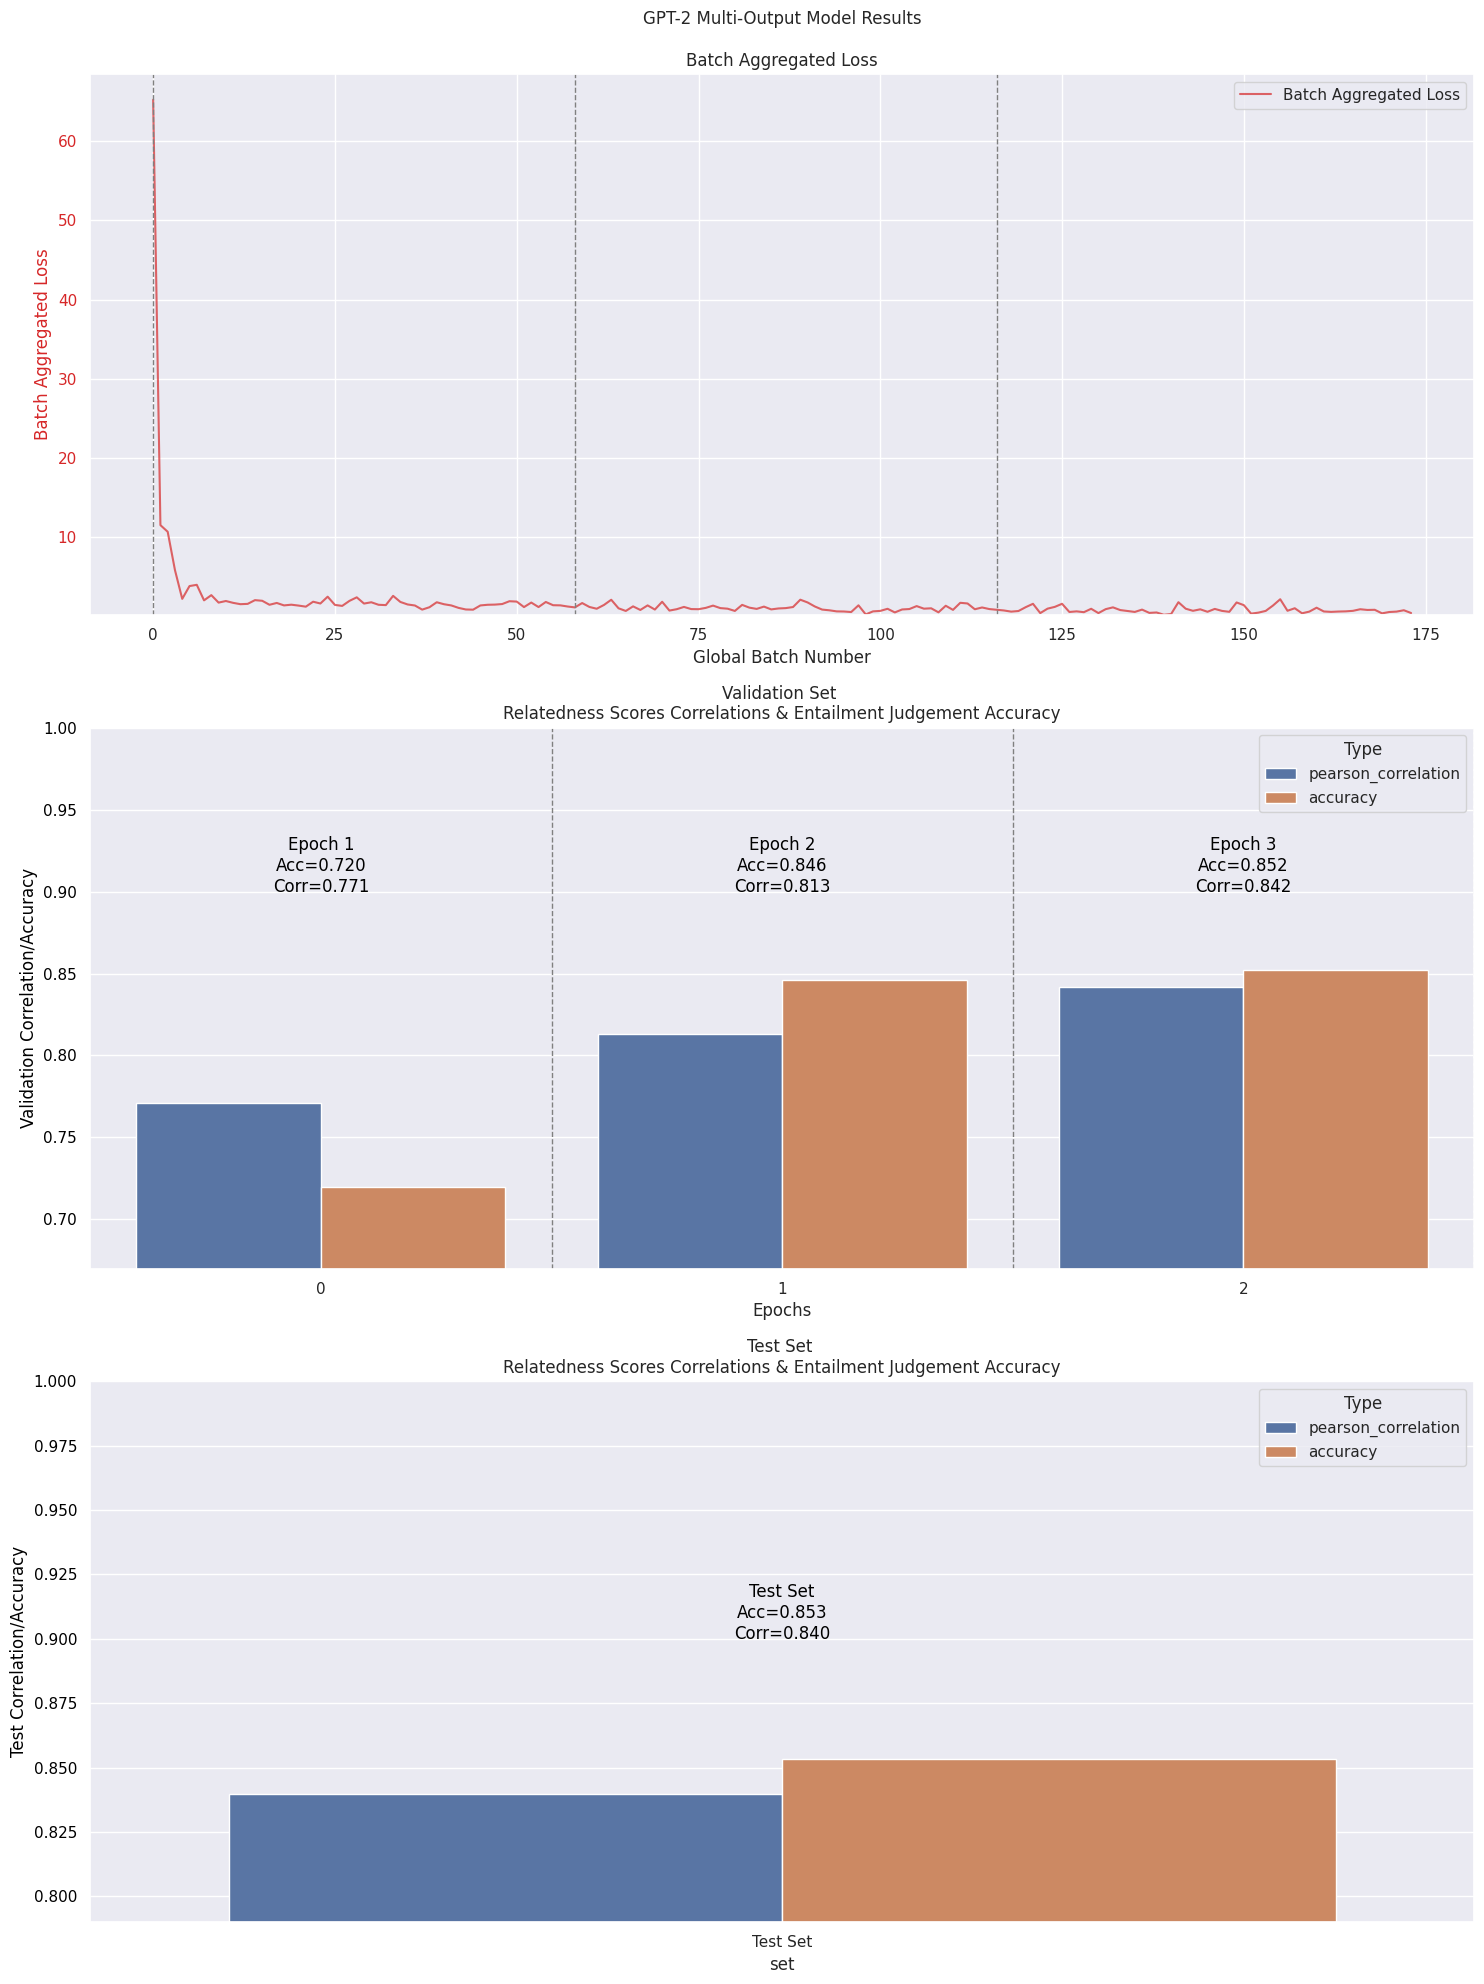

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
sns.set_theme()

output_dir = "./results/gpt2_multioutput_model_results"
os.makedirs(output_dir, exist_ok=True)

# batches_loss = pd.read_csv(f"{output_dir}/batches_loss.csv")
# epoch_val_acc_corr = pd.read_csv(f"{output_dir}/epoch_val_acc_corr.csv")

batches_loss['global_batch'] = range(len(batches_loss))

# Calculate the position for epoch markers
epoch_boundaries = batches_loss.groupby('epoch')['global_batch'].min().tolist()
epoch_boundaries.append(len(batches_loss)) 

# Get the center of each epoch
epoch_centers = [(epoch_boundaries[i] + epoch_boundaries[i+1]) / 2 for i in range(len(epoch_boundaries)-1)]


# Create the plot
fig, ax = plt.subplots(3,1, figsize=(15, 20))

ax1=ax[0]
# Plot batch loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Global Batch Number')
ax1.set_ylabel('Batch Aggregated Loss', color=color)
sns.lineplot(data=batches_loss, x='global_batch', y='agg_loss', ax=ax1, color=color, alpha=0.7, label='Batch Aggregated Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=min(batches_loss["agg_loss"]))

# Create a secondary y-axis for accuracy
# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('Validation Accuracy', color=color)
# sns.lineplot(data=epoch_val_acc_corr, x=epoch_centers, y='accuracy', ax=ax2, color=color, marker='o', linestyle='--', label='Validation Accuracy')
# color = 'tab:green'
# ax2.set_ylabel('Validation Pearson Correlation', color=color)
# sns.lineplot(data=epoch_val_acc_corr, x=epoch_centers, y='pearson_correlation', ax=ax2, color=color, marker='o', linestyle='--', label='Validation Pearson Correlation')
# ax2.tick_params(axis='y', labelcolor=color)
# # ax2.set_ylim(min(epoch_val_acc["accuracy"])-0.05, max(epoch_val_acc["accuracy"])+0.05)
# ax2.set_ylim(min([min(epoch_val_acc_corr["pearson_correlation"]), min(epoch_val_acc_corr["accuracy"])])-0.05, 1)

# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('Batch Classification Loss', color=color)
# sns.lineplot(data=batches_loss, x="global_batch", y='class_loss', ax=ax2, color=color, label='Batch Classification Loss')
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(min(batches_loss["class_loss"]))

ax2=ax[1]
# Plot batch loss on the primary y-axis
color = 'black'
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Correlation/Accuracy', color=color)
# sns.lineplot(data=batches_loss, x='global_batch', y='reg_loss', ax=ax2, color=color, alpha=0.7, label='Batch Regression Loss')
sns.barplot(data=melted_epoch_val_acc_corr, x="epoch", y="Value", hue="Type", ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(min([min(epoch_val_acc_corr["pearson_correlation"]), min(epoch_val_acc_corr["accuracy"])])-0.05, 1)

ax3=ax[2]

color = "black"
# ax3.set_xlabel('Test Set')
ax3.set_ylabel('Test Correlation/Accuracy', color=color)
# sns.lineplot(data=batches_loss, x='global_batch', y='reg_loss', ax=ax3, color=color, alpha=0.7, label='Batch Regression Loss')
sns.barplot(data=melted_epoch_test_acc_corr, x="set", y="Value", hue="Type", ax=ax3)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(min([min(test_results_df["pearson_correlation"]), min(test_results_df["accuracy"])])-0.05, 1)
# ax3.bar_label(ax3.containers[0])
# ax3.bar_label(ax3.containers[1])
ax3.text("Test Set", ax3.get_ylim()[1] * 0.90, f'Test Set\nAcc={test_results_df.iloc[0]["accuracy"]:.3f}\nCorr={test_results_df.iloc[0]["pearson_correlation"]:.3f}', horizontalalignment='center', color='black')

# Add vertical lines and text for epoch boundaries
for i, (boundary, epoch) in enumerate(zip(epoch_boundaries[:-1], epoch_val_acc_corr["epoch"])):
# for i, boundary in enumerate(epoch_boundaries[:-1]):
    epoch_align = epoch
    epoch_sep = epoch+0.5
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1)
    ax2.axvline(x=epoch_sep, color='gray', linestyle='--', linewidth=1)
    # Add text label for the epoch
    ax2.text(epoch_align, ax2.get_ylim()[1] * 0.90, f'Epoch {i+1}\nAcc={epoch_val_acc_corr.iloc[i]["accuracy"]:.3f}\nCorr={epoch_val_acc_corr.iloc[i]["pearson_correlation"]:.3f}', horizontalalignment='center', color='black')

# plt.title("")
ax1.set_title('GPT-2 Multi-Output Model Results\n\nBatch Aggregated Loss')
ax2.set_title('Validation Set \nRelatedness Scores Correlations & Entailment Judgement Accuracy')
ax3.set_title('Test Set \nRelatedness Scores Correlations & Entailment Judgement Accuracy')
fig.tight_layout()
plt.savefig(f"{output_dir}/reg_class_loss_acc_corr_model.png")

plt.tight_layout()
# plt.show()

In [17]:
batches_loss.to_csv(f"{output_dir}/batches_loss.csv")
epoch_val_acc_corr.to_csv(f"{output_dir}/epoch_val_acc_corr.csv")

In [18]:
import pandas as pd
import numpy as np
from collections import Counter
test_data = SemevalDataset(split="test").data
test_data_df = pd.DataFrame(test_data)
results_test_df = pd.DataFrame({"Real_Rel_Scores": real_rel_scores, "Pred_Rel_Scores": pred_rel_scores, "Real_Entail_Classes": real_entail_classes, "Pred_Entail_Classes": pred_entail_classes})
results_test_df = pd.concat([test_data_df, results_test_df], axis=1)

sorted_results_test_df = results_test_df.sort_values(by="Real_Rel_Scores", ignore_index=True)
sorted_results_test_df["index"] = range(0, len(sorted_results_test_df))

label_map = {0: "Neutral", 1: "Entailment", 2: "Contradiction"}
sorted_results_test_df["Real_Entail_Classes_Map"] = sorted_results_test_df["Real_Entail_Classes"].apply(lambda x: label_map[x])
sorted_results_test_df["Pred_Entail_Classes_Map"] = sorted_results_test_df["Pred_Entail_Classes"].apply(lambda x: label_map[x])
print(sorted_results_test_df.head(5))

count_labels_real = Counter(sorted_results_test_df["Real_Entail_Classes_Map"])
count_labels_pred = Counter(sorted_results_test_df["Pred_Entail_Classes_Map"])
count_labels_real_df = pd.DataFrame({"Label": count_labels_real.keys(), "Groundtruth": count_labels_real.values()}, columns=["Label", "Groundtruth"])
count_labels_pred_df = pd.DataFrame({"Label": count_labels_pred.keys(), "Predictions": count_labels_pred.values()}, columns=["Label", "Predictions"])
count_labels_df = count_labels_real_df.merge(count_labels_pred_df, on="Label")
print(count_labels_df)

melted_df = count_labels_df.melt(id_vars="Label", var_name="Type", value_name="Count")
print(melted_df)


   sentence_pair_id                                            premise  \
0              9996  A man is in a parking lot and is playing tenni...   
1              9995  The girl, who is little, is combing her hair i...   
2              9994                 A boy is happily playing the piano   
3              1316                A person is performing a card trick   
4              9979  A person is wearing a straw hat and smoking a ...   

                                          hypothesis  relatedness_score  \
0  The snowboarder is leaping fearlessly over whi...                1.0   
1  Two people wearing helmets are driving over th...                1.0   
2       A white bird is landing swiftly in the water                1.0   
3                  There is no man frying a tortilla                1.0   
4              A dog is near the red ball in the air                1.0   

   entailment_judgment  Real_Rel_Scores  Pred_Rel_Scores  Real_Entail_Classes  \
0                    0 

In [19]:
sorted_results_test_df.to_csv(f"{output_dir}/full_results_test_set.csv")

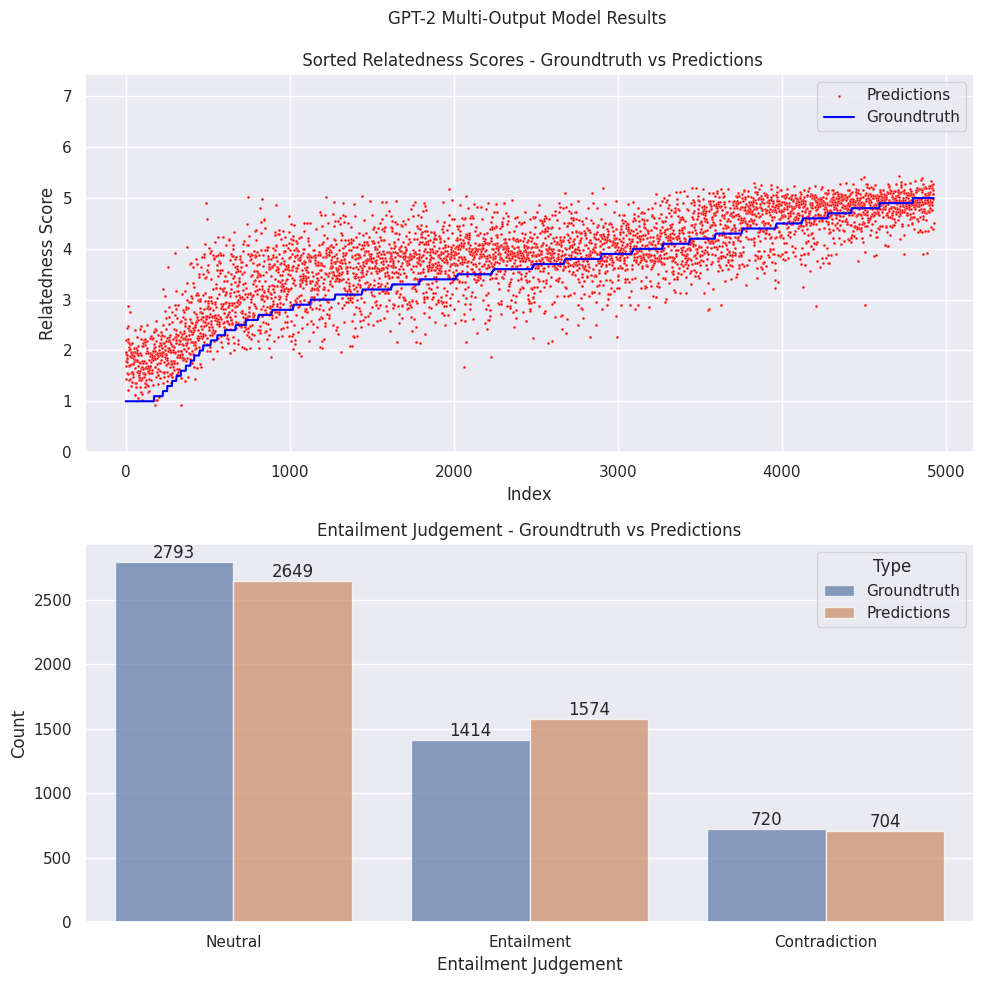

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.dpi = 100

sns.scatterplot(data=sorted_results_test_df, x="index", y="Pred_Rel_Scores", color="red", label="Predictions", s=4, ax=ax[0])
sns.lineplot(data=sorted_results_test_df, x="index", y="Real_Rel_Scores", color="blue", label="Groundtruth", ax=ax[0])

ax[0].set_ylim(0, max(sorted_results_test_df["Pred_Rel_Scores"])+2)
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Relatedness Score")
ax[0].set_title("GPT-2 Multi-Output Model Results \n\n Sorted Relatedness Scores - Groundtruth vs Predictions")

sns.barplot(data=melted_df, x = "Label", y="Count", hue="Type", ax=ax[1], alpha=0.7)
ax[1].bar_label(ax[1].containers[0])
ax[1].bar_label(ax[1].containers[1])
ax[1].set_xlabel("Entailment Judgement")
ax[1].set_ylabel("Count")
ax[1].set_title("Entailment Judgement - Groundtruth vs Predictions")
fig.tight_layout()
plt.savefig(f"{output_dir}/rel_score_ent_judg_graphs.png")

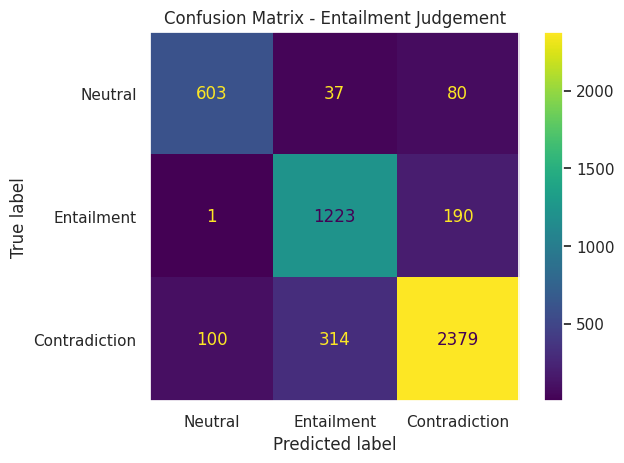

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(sorted_results_test_df["Real_Entail_Classes_Map"], sorted_results_test_df["Pred_Entail_Classes_Map"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Entailment", "Contradiction"])
disp.plot()
plt.title("Confusion Matrix - Entailment Judgement")
plt.grid(visible=False)
plt.savefig(f"{output_dir}/confusion_matrix_ent_judge.png")
plt.show()

In [22]:
from sklearn.metrics import classification_report

report = classification_report(sorted_results_test_df["Real_Entail_Classes_Map"], sorted_results_test_df["Pred_Entail_Classes_Map"])
print(report)

               precision    recall  f1-score   support

Contradiction       0.86      0.84      0.85       720
   Entailment       0.78      0.86      0.82      1414
      Neutral       0.90      0.85      0.87      2793

     accuracy                           0.85      4927
    macro avg       0.84      0.85      0.85      4927
 weighted avg       0.86      0.85      0.85      4927



In [23]:
sorted_results_test_df.describe()

,sentence_pair_id,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,5001.250457,3.530021,0.579257,3.530021,3.810928,0.579257,0.605236,2463.000000
std,2915.057191,1.008868,0.732185,1.008868,0.906595,0.732185,0.724434,1422.446718
min,6.000000,1.000000,0.000000,1.000000,0.928526,0.000000,0.000000,0.000000
25%,2457.000000,3.000000,0.000000,3.000000,3.323396,0.000000,0.000000,1231.500000
50%,5038.000000,3.600000,0.000000,3.600000,3.903149,0.000000,0.000000,2463.000000
75%,7523.500000,4.300000,1.000000,4.300000,4.519424,1.000000,1.000000,3694.500000
max,9996.000000,5.000000,2.000000,5.000000,5.443279,2.000000,2.000000,4926.000000


In [24]:
sorted_results_test_df["Rel_Score_Diff"] = sorted_results_test_df.apply(lambda row: abs(row.Real_Rel_Scores-row.Pred_Rel_Scores), axis=1)
sorted_rel_score_diff_df = sorted_results_test_df.sort_values(by="Rel_Score_Diff", ignore_index=True)
sorted_rel_score_diff_df[-5:]

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map,Rel_Score_Diff
4922,1837,A magician is cutting a girl into two pieces l...,Tofu is being sliced by a woman,1.3,0,1.3,3.643193,0,0,261,Neutral,Neutral,2.343194
4923,4741,A person is performing tricks on a motorcycle,The performer is tricking a person on a motorc...,2.6,0,2.6,5.017025,0,1,745,Neutral,Entailment,2.417025
4924,6718,A dead bird is near a black man sitting on a tree,A black bird is sitting on a dead tree,2.1,0,2.1,4.581356,0,1,499,Neutral,Entailment,2.481356
4925,8320,A horse is running,Dogs are racing on a track,1.4,0,1.4,3.915822,0,0,301,Neutral,Neutral,2.515822
4926,4873,Carrots are being sliced by a woman,A woman is cutting potatoes,2.1,0,2.1,4.899556,0,1,492,Neutral,Entailment,2.799556
